# Segmentation of Indian Traffic

In [ ]:
import math
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib


<pre>

1. All your data will be in the folder "data" 

2. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

## 1. Get all the file name and corresponding json files

In [ ]:
import re
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    image_path=[]
    json_path=[]

    def sort_path(path):
      x=list(map(int,re.findall(r"\d+",path)))
      return x[0]


    for i in os.listdir(root_dir):
      if i=='images':

        screens = sorted(list(map(int,os.listdir(os.path.join(root_dir,i)))))

        for j in screens:

          paths=sorted(os.listdir(os.path.join(root_dir,i,str(j))),key=sort_path)
          
          for k in paths:
            image_path.append(os.path.join(root_dir,i,str(j),str(k)))

          
      else:

        screens = sorted(list(map(int,os.listdir(os.path.join(root_dir,i)))))

        for j in screens:

          paths=sorted(os.listdir(os.path.join(root_dir,i,str(j))),key=sort_path)
          
          for k in paths:
            json_path.append(os.path.join(root_dir,i,str(j),str(k)))

          


    data_df=pd.DataFrame(np.hstack((np.array([image_path]).reshape(-1,1),np.array([json_path]).reshape(-1,1))),columns=['images','json'])

    
    return data_df

In [ ]:
data_df = return_file_names_df("data")
data_df.head()

,images,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:

grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
print(data_df['json'][0])
f = open(data_df['json'][0])

data=json.load(f)

for i in data['objects']:
  print(i)
f.close()

data/mask/201/frame0029_gtFine_polygons.json
{'date': '14-Jun-2019 17:26:53', 'deleted': 0, 'draw': True, 'id': 0, 'label': 'road', 'polygon': [[1094.3204419889503, 572.817679558011], [1372.375690607735, 553.7237569060774], [1919.0, 699.2307692307692], [1919.0, 708.4615384615385], [1919.0, 714.2307692307692], [1919.0, 703.8461538461538], [1919.0, 1079.0], [0.0, 1079.0], [0.0, 759.2307692307692], [999.2307692307692, 572.3076923076923], [1084.7734806629835, 572.817679558011], [1089.546961325967, 575.2044198895028], [1089.546961325967, 575.2044198895028], [1090.7403314917128, 575.2044198895028], [1090.7403314917128, 575.2044198895028], [1101.4806629834254, 572.817679558011], [1101.4806629834254, 572.817679558011]], 'user': 'cvit', 'verified': 0}
{'date': '08-Jul-2019 11:36:05', 'deleted': 0, 'draw': True, 'id': 1, 'label': 'drivable fallback', 'polygon': [[1168.3093922651935, 584.7513812154697], [1150.4088397790056, 594.2983425414365], [1132.5082872928178, 602.6519337016575], [1132.508287

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels=set()
    for i in data_df['json']:

      f=open(i)
      data=json.load(f)

      for j in data['objects']:

        unique_labels.add(j['label'])

    return unique_labels

In [ ]:
unique_labels=return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image

    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image

    f=open(file)
    data=json.load(f)

    h=data['imgHeight']
    w=data['imgWidth']
    vertexlist=[]
    label=[]
    for i in data['objects']:
      if len(i['polygon'])>=2:
        label.append(i['label'])
        list_of_co_ordinates=[]
        for j in i['polygon']:
          if len(j)==2:
            list_of_co_ordinates.append(tuple(j))
          else:
            print(len(j))
        vertexlist.append(list_of_co_ordinates)

    return w, h, label, vertexlist

In [ ]:
w,h,label,vertex=get_poly('data/mask/201/frame0029_gtFine_polygons.json')
len(label),len(vertex),w,h

(227, 227, 1920, 1080)

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

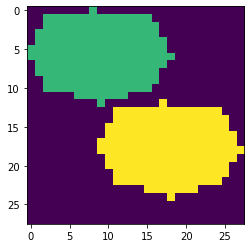

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

## Mask 

In [ ]:
from tqdm import tqdm
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    output_paths=[]
    for i in tqdm(data_df['json']):

      w,h,label,vertexlist=get_poly(i)
      img=Image.new("RGB",(w,h))
      img1=ImageDraw.Draw(img)
      for j in range(len(label)):
        img1.polygon(vertexlist[j],fill=label_clr[label[j]])
      
      path=re.sub("mask","output",i)
      path=re.sub("json","png",path)
      
      directory=re.findall("data/output/\d+",path)[0]
      if os.path.isdir(directory):
        img.save(path)

      else:

        os.makedirs(directory)
        img.save(path)
      
      output_paths.append(path)
    data_df['output']=np.array([output_paths]).reshape(-1,1)
    return data_df

In [ ]:
final_data_df=compute_masks(data_df)

100%|██████████| 4008/4008 [06:30<00:00, 10.26it/s]


In [ ]:
final_data_df.head()

,images,json,output
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


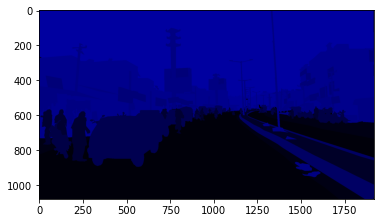

In [ ]:
plt.imshow(cv2.imread(final_data_df['output'][0],cv2.IMREAD_UNCHANGED))

In [ ]:
#daving the final dataframe to a csv file
final_data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

### Task 2.1: Dice loss

Dice loss = 1 - dice coefficient

where dice coefficient = $\frac{2TP}{2TP+FP+FN}$ 

Range of a loss function is {${0,1}$}

If model predicts  all True Positives correctly then dice coefficient will be $1$ and dice loss becomes 0  else dice loss will be in between {${0,1}$}  

we can use cross-entropy loss as well but it is sensitive to imbalance dataset , In image segmentation we will deal with images which are having imbalanced labels because of this cross-entropy will not give proper measurement of True positives, people often use dice loss or iou loss for image segmentation task which penalizes the false positives and measure the True positive rate efficiently when compares to cross entropy , they are more robust to imbalance data and it can be  differentiable where we can easily back-propagate to updates weights

### Task 2.2: Training Unet

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this task we won't writing this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

</pre>


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
</pre>

## **split data**

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test=train_test_split(final_data_df[["images","output"]],test_size=0.1,random_state=42)

In [ ]:
X_test,X_val=train_test_split(final_data_df[["images","output"]],test_size=0.5,random_state=42)

In [ ]:
len(X_train),len(X_test),len(X_val)

(3607, 2004, 2004)

In [ ]:
X_test.head(2)

,images,output
1801,data/images/302/frame17538_leftImg8bit.jpg,data/output/302/frame17538_gtFine_polygons.png
1628,data/images/288/frame21619_leftImg8bit.jpg,data/output/288/frame21619_gtFine_polygons.png


## Dataset building

In [ ]:
import imgaug.augmenters as iaa

def normalize(img):
  return (img/255).astype("float")

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

class Dataset:
  
  def __init__(self,dataframe,classes,training=True):

    self.Classes={'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
    self.training=training
    
    self.image_paths=dataframe["images"].reset_index(drop=True)
    self.output_paths=dataframe['output'].reset_index(drop=True)
    self.labels=sorted(list(set(self.Classes[i] for i in classes)))
 
  def __getitem__(self,i):

    image = cv2.imread(self.image_paths[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(512,512),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=normalize(image)
    
    mask  = cv2.imread(self.output_paths[i], cv2.IMREAD_UNCHANGED)
    mask= cv2.resize(mask,(512,512),interpolation=cv2.INTER_AREA)
    
   

    if self.training:
      a = np.random.uniform()
      if a<0.2:
        image = aug2.augment_image(image)
        image_mask = aug2.augment_image(mask)
      elif a<0.4:
        image = aug3.augment_image(image)
        image_mask = aug3.augment_image(mask)
      elif a<0.6:
        image = aug4.augment_image(image)
        image_mask = aug4.augment_image(mask)
      elif a<0.8:
        image = aug5.augment_image(image)
        image_mask = aug5.augment_image(mask)
      else:
        image = aug6.augment_image(image)
        image_mask = aug6.augment_image(mask)

      ohe_mask=[(image_mask[:,:,2]==i) for i in self.labels]
      onehotenocded=np.stack(ohe_mask,axis=-1).astype('float')
    
      return image, onehotenocded
    else:

      ohe_mask=[(mask[:,:,2]==i) for i in self.labels]
      onehotenocded=np.stack(ohe_mask,axis=-1).astype('float')

      return image , onehotenocded
    
  def __len__(self):
    return len(self.image_paths)



## Data generator

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
pip install segmentation_models

     |████████████████████████████████| 50 kB 7.4 MB/s 


## Model

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

from segmentation_models import Unet
# prepare model
tf.keras.backend.clear_session()
model1 = Unet(backbone_name='resnet101', encoder_weights='imagenet',decoder_use_batchnorm =True,classes=21,activation='softmax',decoder_filters=(512,256,128,64,32),encoder_freeze=False,input_shape=(512,512,3))

Segmentation Models: using `keras` framework.
171180032/171164896 [==============================] - 5s 0us/step


In [ ]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']   

In [ ]:
CLASSES = unique_labels
train_dataset = Dataset(X_train, classes=CLASSES,training=True)
test_dataset  = Dataset(X_test, classes=CLASSES,training=False)
val_dataset  = Dataset(X_val, classes=CLASSES,training=False)


train_dataloader = Dataloder(train_dataset, batch_size=5, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=4, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=4, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (5, 512, 512, 3)
assert train_dataloader[0][1].shape == (5, 512, 512, 21)  

(5, 512, 512, 3)


In [ ]:
import segmentation_models as sm
from segmentation_models.metrics import IOUScore

optim = tf.keras.optimizers.Adam(0.00001)
focal_loss = sm.losses.cce_dice_loss
model1.compile(optimizer=optim, loss=focal_loss,metrics=[IOUScore(threshold=0.5)])

## Training

In [ ]:
def scheduler(epoch, lr):
 if epoch%2==0:
   return 0.6*lr
 else:
   return lr
lrdecay=tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model_103_.h5', save_weights_only=True, save_best_only=True)]
model1.load_weights('./best_model_102_.h5')
history = model1.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,\
                              validation_data=val_dataloader,callbacks=callbacks,)

Epoch 1/30
721/721 [==============================] - 754s 1s/step - loss: 0.5327 - iou_score: 0.4085 - val_loss: 0.5547 - val_iou_score: 0.4725
Epoch 2/30
721/721 [==============================] - 750s 1s/step - loss: 0.5314 - iou_score: 0.4098 - val_loss: 0.5510 - val_iou_score: 0.4735
Epoch 3/30
721/721 [==============================] - 746s 1s/step - loss: 0.5271 - iou_score: 0.4142 - val_loss: 0.5505 - val_iou_score: 0.4800
Epoch 4/30
721/721 [==============================] - 756s 1s/step - loss: 0.5207 - iou_score: 0.4206 - val_loss: 0.5495 - val_iou_score: 0.4762
Epoch 5/30
721/721 [==============================] - 755s 1s/step - loss: 0.5243 - iou_score: 0.4179 - val_loss: 0.5464 - val_iou_score: 0.4784
Epoch 6/30
721/721 [==============================] - 753s 1s/step - loss: 0.5182 - iou_score: 0.4229 - val_loss: 0.5452 - val_iou_score: 0.4804
Epoch 7/30
721/721 [==============================] - 756s 1s/step - loss: 0.5158 - iou_score: 0.4253 - val_loss: 0.5444 - val_iou

**Model evaluation**

In [ ]:
model1.load_weights('./best_model_103_.h5')

In [ ]:
model1.evaluate(test_dataloader)

501/501 [==============================] - 242s 482ms/step - loss: 0.5083 - iou_score: 0.5306


[0.5083001255989075, 0.530604362487793]

## Model Performance

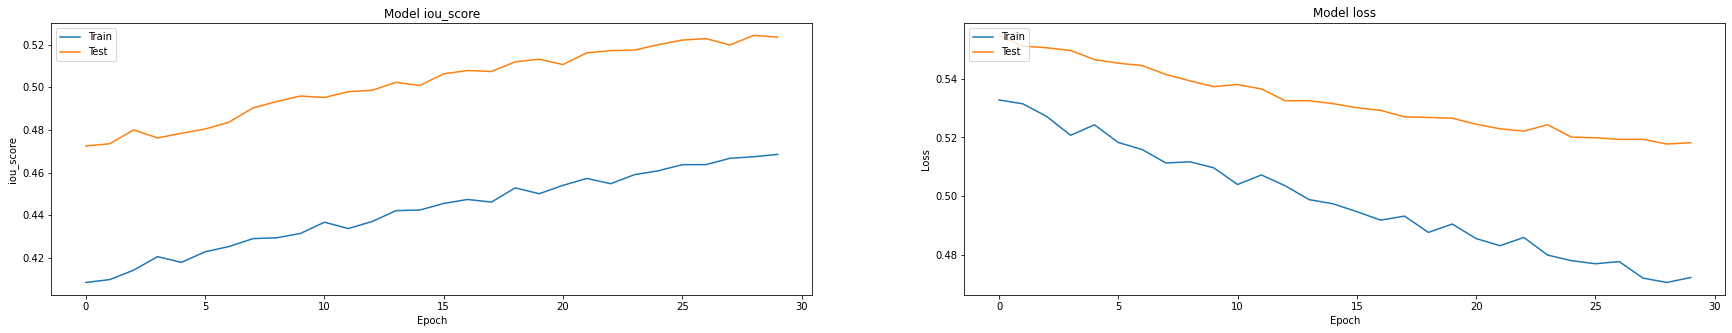

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## **Predictions**

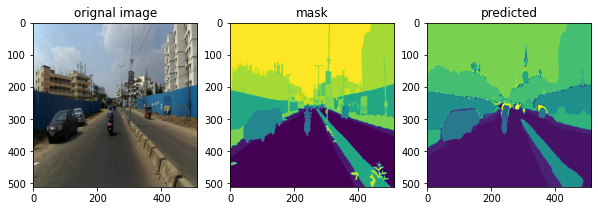

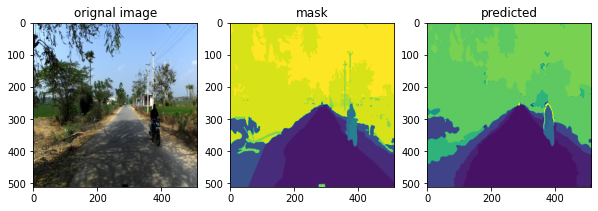

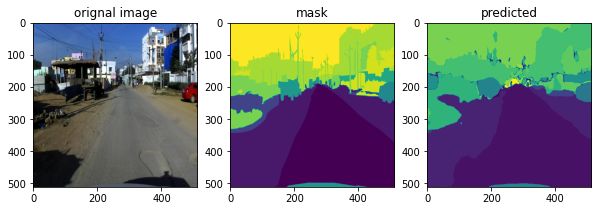

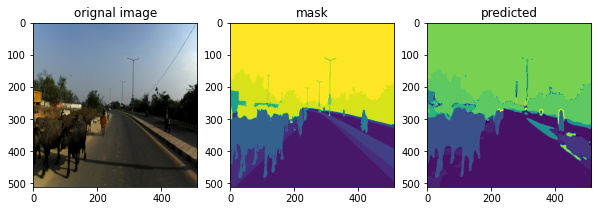

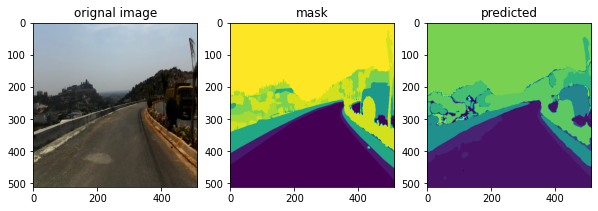

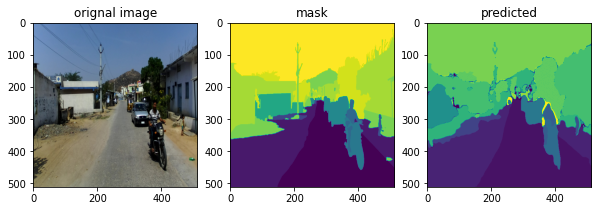

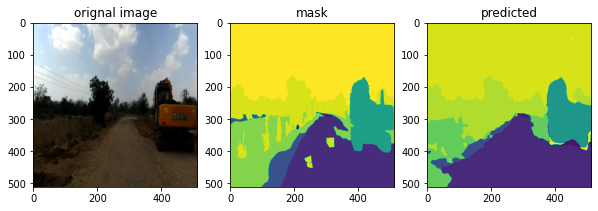

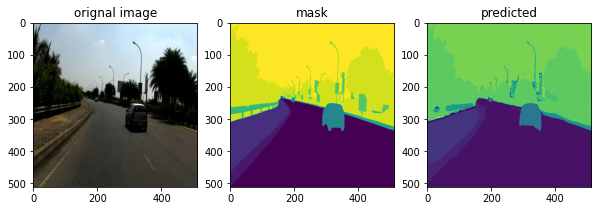

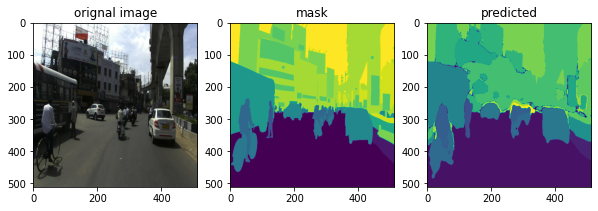

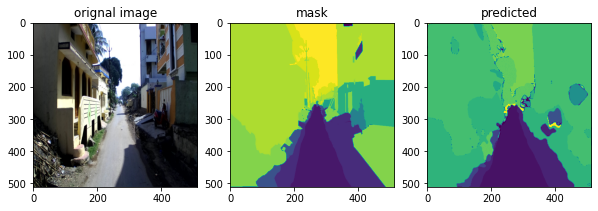

In [ ]:
plot_images=X_val[:10].reset_index(drop=True)
x=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,18,190,200]

for p, i in enumerate(range(10)):
    #original image
    image = cv2.imread(plot_images['images'][p], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=normalize(image)
    
    
    #predicted segmentation map
    predicted  =np.where(model1.predict(np.array([image]))>0.5,1,0)
   
    m=np.zeros((512,512))
    for j , k in enumerate(x):
      b=np.where(predicted[0][:,:,j]==1,k,0)
      m=m+b

    
    #original segmentation map
    image_mask = cv2.imread(plot_images['output'][p], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))[:,:,2]

    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image,)
    plt.title("orignal image")
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.title("mask")
    plt.subplot(133)
    plt.imshow(m)
    plt.title("predicted")
    plt.show()

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this task we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
tf.keras.backend.clear_session()
class convolutional_block(tf.keras.layers.Layer):

    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="convolutional_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv1=Conv2D(filters=self.F1,kernel_size=1,padding='same',name=name+"_c1")
        self.batch_1=BatchNormalization(name=name+"_b1")
        
        self.conv2=Conv2D(filters=self.F2,kernel_size=self.kernel,strides=self.stride,padding='same',name=name+"_c2")
        self.batch_2=BatchNormalization(name=name+"_b2")
        
        self.conv3=Conv2D(filters=self.F3,kernel_size=1,padding='same',name=name+"_c3")
        self.batch_3=BatchNormalization(name=name+"_b3")


        self.conv_parallel=Conv2D(filters=self.F3,kernel_size=self.kernel,strides=self.stride,padding='same',name=name+"_c_parallel")
        self.batch_parallel=BatchNormalization(name=name+"_b_parallel")
        
        
        self.add=Add()
        self.activation=Activation("relu")

    def call(self, X):
        # write the architecutre that was mentioned above
        x=X
        
        #first conv block
        conv_1=self.conv1(x)
        batch1=self.batch_1(conv_1)
        activation1=self.activation(batch1)
        
        #second conv block
        conv_2=self.conv2(activation1)
        batch2=self.batch_2(conv_2)
        activation2=self.activation(batch2)

        #third conv block
        conv_3=self.conv3(activation2)
        batch3=self.batch_3(conv_3)

        #skip block
        conv_ii=self.conv_parallel(x)
        batch_ii=self.batch_parallel(conv_ii)
        activation_ii=self.activation(batch_ii)

        X=self.add([batch3,activation_ii])

        return X

In [ ]:

tf.keras.backend.clear_session()
X=Input(shape=(512,512,3))

conv1=convolutional_block(stride=8)(X)
model=Model(X,conv1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 convolutional_block (convol  (None, 64, 64, 8)        524       
 utional_block)                                                  
                                                                 
Total params: 524
Trainable params: 476
Non-trainable params: 48
_________________________________________________________________


In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv1=Conv2D(filters=self.F1,kernel_size=self.kernel,padding='same',name=name+"_c1")
        self.batch_1=BatchNormalization(name=name+"_b1")
        self.conv2=Conv2D(filters=self.F2,kernel_size=self.kernel,padding='same',name=name+"_c2")
        self.batch_2=BatchNormalization(name=name+"_b2")
        self.conv3=Conv2D(filters=self.F3,kernel_size=self.kernel,padding='same',name=name+"_c3")
        self.batch_3=BatchNormalization(name=name+"_b3")
        self.add=Add()
        self.activation=Activation("relu")
   
    def call(self, X):
        # write the architecutre that was mentioned above
        X_parallel=X

        #first conv block
        conv_1=self.conv1(X_parallel)
        batch1=self.batch_1(conv_1)
        activation_1=self.activation(batch1)
        
        #second conv block
        conv_2=self.conv2(activation_1)
        batch2=self.batch_2(conv_2)
        activation_2=self.activation(batch2)

        #third conv block
        conv_3=self.conv3(activation_2)
        batch3=self.batch_3(conv_3)

      
        x=self.add([batch3,X_parallel])

        return x

In [ ]:
tf.keras.backend.clear_session()
X=Input(shape=(64, 64, 8))

conv1=identity_block()(X)
model=Model(X,conv1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 8)]       0         
                                                                 
 identity_block (identity_bl  (None, 64, 64, 8)        800       
 ock)                                                            
                                                                 
Total params: 800
Trainable params: 768
Non-trainable params: 32
_________________________________________________________________


* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, inputshape,name="global_flow"):
        super().__init__(name=name)

        self.inputshape=inputshape
        self.global_average=GlobalAveragePooling2D()
        self.batch_norm=BatchNormalization()
        self.activation=Activation('relu')
        self.conv2d=Conv2D(32,kernel_size=1,padding='same')
        self.upsample=tf.keras.layers.UpSampling2D(size=(self.inputshape[0],self.inputshape[1]),interpolation='bilinear')
    def call(self, X):
        # implement the global flow operatiom
        x=self.global_average(X)
        x=self.batch_norm(x)
        x=self.activation(x)
      
        x=tf.expand_dims(x,1)
        x=tf.expand_dims(x,1)
        x=self.conv2d(x)
        x=self.upsample(x)

        return x

In [ ]:
tf.keras.backend.clear_session()
X=Input(shape=(64, 64, 8))

conv1=global_flow(inputshape=(64, 64, 8))(X)
model=Model(X,conv1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 8)]       0         
                                                                 
 global_flow (global_flow)   (None, 64, 64, 32)        320       
                                                                 
Total params: 320
Trainable params: 304
Non-trainable params: 16
_________________________________________________________________


In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.averagepool=AveragePooling2D(pool_size=(2,2))
        self.batch_norm=BatchNormalization()

        self.activation_relu=Activation('relu')
        self.activation_sigmoid=Activation('sigmoid')

        self.conv2d1=Conv2D(32,kernel_size=3,padding='same')
        self.conv2d2=Conv2D(32,kernel_size=3,padding='same')
        self.conv2d_1=Conv2D(32,kernel_size=1,padding='same')
        self.conv2d_2=Conv2D(32,kernel_size=1,padding='same')

        self.upsample=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
        self.concatenate=Concatenate()
        self.add=Add()
        self.multiply = Multiply()
 
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cel]
        
        concat=self.concatenate([FLOW,INP])
        Avrgpool=self.averagepool(concat)
        conv_1=self.conv2d1(Avrgpool)
        conv_2=self.conv2d2(conv_1)

        #context refinement modle

        conv_3=self.conv2d_1(conv_2)
        activation_1=self.activation_relu(conv_3)
        batch_1=self.batch_norm(activation_1)
        conv2d_4=self.conv2d_2(batch_1)
        activation_2=self.activation_sigmoid(conv2d_4)


        multiplication=self.multiply([conv_2,activation_2])
        add=self.add([multiplication,conv_2])
        x=self.upsample(add)

        return x

In [ ]:
tf.keras.backend.clear_session()
X=Input(shape=(64, 64, 32))
y=Input(shape=(64, 64, 64))
conv1=context_flow()([X,y])
model=Model([X,y],conv1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 context_flow (context_flow)    (None, 64, 64, 32)   39168       ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.global_pool=GlobalAveragePooling2D()
        self.upsample=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')

        self.conv2d_1=Conv2D(32,kernel_size=1,padding='same')
        self.conv2d_3=Conv2D(32,kernel_size=3,padding='same')

        self.batch_norm=BatchNormalization()
        self.activation_sigmoid=Activation("sigmoid")

    def call(self, X):
        # implement the FSM modules based on image in the above cells

        x_in=self.conv2d_3(X)
        x=self.global_pool(x_in)
        x= tf.expand_dims(x, 1)
        x = tf.expand_dims(x, 1)
        x= self.conv2d_1(x)
        x=self.batch_norm(x)
        x=self.activation_sigmoid(x)
        
        FSM_Conv_T=tf.math.multiply(x,x_in)
        FSM_Conv_T=self.upsample(FSM_Conv_T)
        return FSM_Conv_T

In [ ]:
tf.keras.backend.clear_session()
X=Input(shape=(64, 64, 32))

conv1=fsm()(X)
model=Model(X,conv1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 32)]      0         
                                                                 
 feature_selection (fsm)     (None, 128, 128, 32)      10432     
                                                                 
Total params: 10,432
Trainable params: 10,368
Non-trainable params: 64
_________________________________________________________________


* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="agcn"):
        super().__init__(name=name)
        self.conv2d_1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv2d_2  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv2d_3  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv2d_4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv2d_5  = Conv2D(32,kernel_size=(3,3),padding='same')
        self.add = Add()
    
    def call(self, X):
        # please implement the above mentioned architecture
        x_1=self.conv2d_1(X)
        x_1=self.conv2d_2(x_1)
        
        x_2=self.conv2d_3(X)
        x_2=self.conv2d_4(x_2)

        x_out=self.add([x_1,x_2])
        
        x=self.conv2d_5(x_out)

        x=self.add([x,x_out])
        
        return x

In [ ]:
tf.keras.backend.clear_session()
X=Input(shape=(128, 128, 8))

conv1=agcn()(X)
model=Model(X,conv1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 8)]     0         
                                                                 
 agcn (agcn)                 (None, 128, 128, 32)      27296     
                                                                 
Total params: 27,296
Trainable params: 27,296
Non-trainable params: 0
_________________________________________________________________


*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [ ]:
X_input = Input(shape=(128,128,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

(None, 64, 64, 64)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

## Model building

In [ ]:
# write the complete architecutre

tf.keras.backend.clear_session()


X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

#c_1 conv block followed by one identity block

conv_1=convolutional_block(stride=2)(X)
identity_1=identity_block(name='identity_block1')(conv_1)

#c_2 conv block follwed by two identity blocks

conv_2=convolutional_block(name="convolutional_block2",stride=2)(identity_1)
identity_21=identity_block(name='identity_block_21')(conv_2)
identity_22=identity_block(name='identity_block_22')(identity_21)

#c_3 conv block followed by three identity blocks

conv_3=convolutional_block(name="convolutional_block3",stride=1)(identity_22)
identity_31=identity_block(name='identity_block_31')(conv_3)
identity_32=identity_block(name='identity_block_32')(identity_31)
identity_33=identity_block(name='identity_block_33')(identity_32)

#c_4 conv block followed by four identity blocks

conv_4=convolutional_block(name="convolutional_block4",stride=1)(identity_33)
identity_41=identity_block(name='identity_block_41')(conv_4)
identity_42=identity_block(name='identity_block_42')(identity_41)
identity_43=identity_block(name='identity_block_43')(identity_42)
identity_44=identity_block(name='identity_block_44')(identity_43)

#global flow

global_flow_1=global_flow((identity_44.shape[1],identity_44.shape[2]))(identity_44)

#context flow 1

context_flow_1=context_flow(name='context_flow1')([global_flow_1,identity_44])

#context flow 2

context_flow_2=context_flow(name='context_flow2')([context_flow_1,identity_44])

#context flow 3

context_flow_3=context_flow(name='context_flow3')([context_flow_2,identity_44])

#context flow 4

context_flow_4=context_flow(name='context_flow4')([context_flow_3,identity_44])

# sum
add=Add()([global_flow_1,context_flow_1,context_flow_2,context_flow_3,context_flow_4])


# feature selection module (FSM)

fsm_1=fsm()(add)

# Adopted Global Convolution Network (AGCN)

agcn_1=agcn()(conv_1)


#concatenate AGCN and FSM

concatenate_agcn_fsm=Concatenate()([agcn_1,fsm_1])


channels_21=Conv2D(filters=21,kernel_size=3,padding='same',activation='relu')(concatenate_agcn_fsm)

#upsample

upsample=UpSampling2D(size=(4,4),interpolation='bilinear')(channels_21)

output=Activation("softmax")(upsample)


model = Model(inputs = X_input, outputs = output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 512, 512, 64  256         ['conv1[0][0]']                  
                                )                                                             

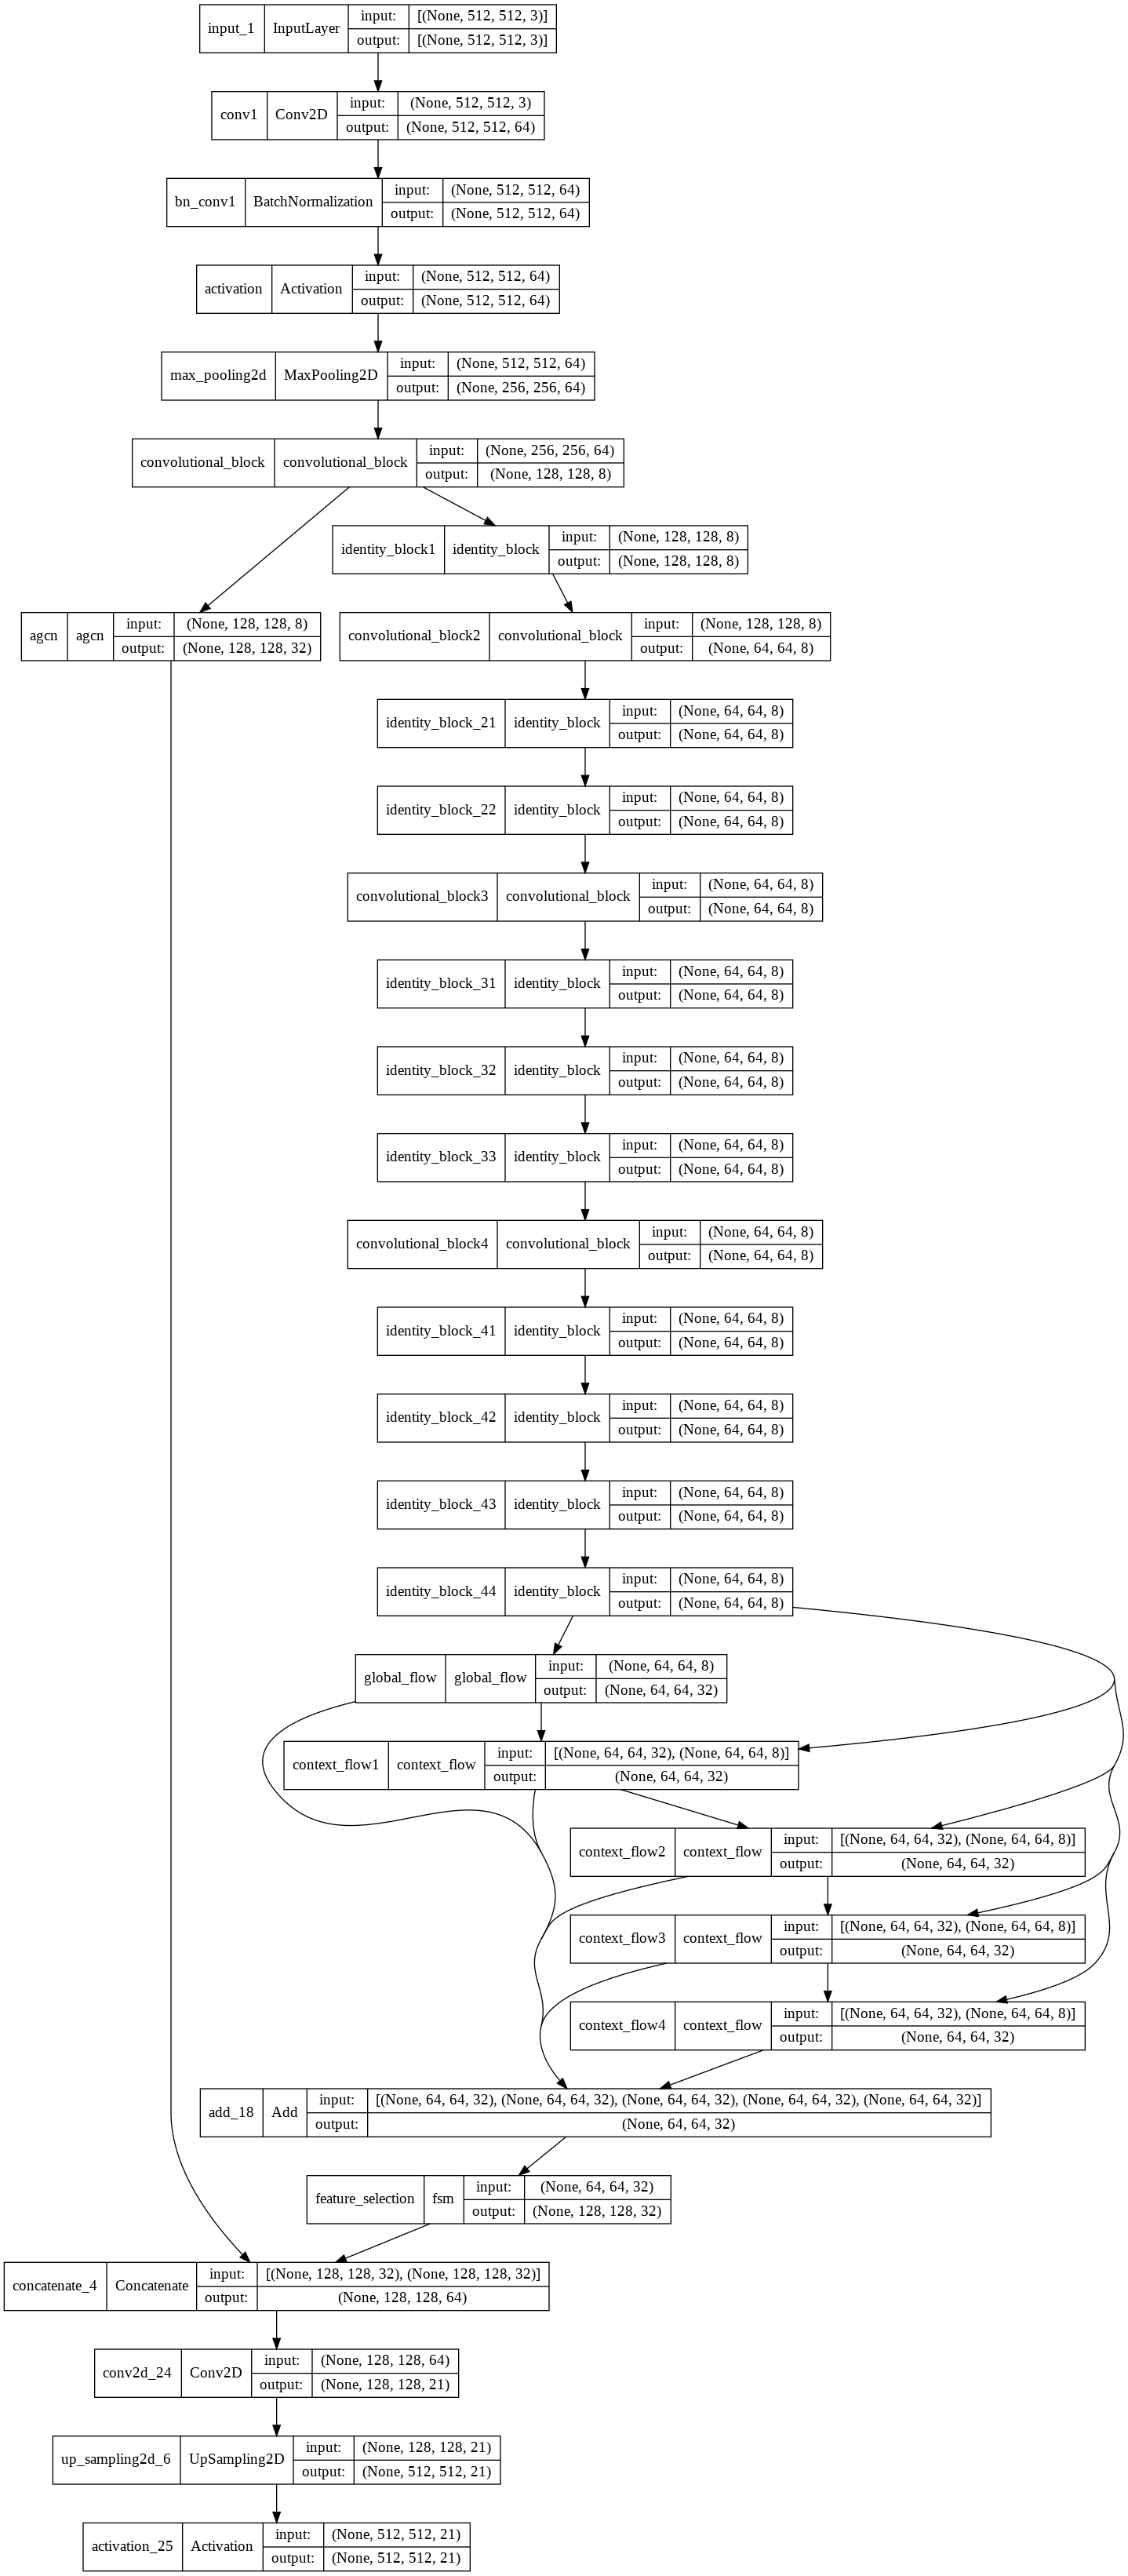

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

## loss function

In [ ]:
import segmentation_models as sm
from segmentation_models.metrics import IOUScore
sm.set_framework('tf.keras')

optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optimizer=optim, loss=focal_loss,metrics=[IOUScore(threshold=0.5)])

## Training

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model3.h5', save_weights_only=True, save_best_only=True)]
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=15,\
                              validation_data=val_dataloader,callbacks=callbacks)

Epoch 1/15
721/721 [==============================] - 584s 810ms/step - loss: 0.7507 - iou_score: 0.2345 - val_loss: 0.7880 - val_iou_score: 0.3927
Epoch 2/15
721/721 [==============================] - 582s 808ms/step - loss: 0.7474 - iou_score: 0.2357 - val_loss: 0.7871 - val_iou_score: 0.3445
Epoch 3/15
721/721 [==============================] - 582s 808ms/step - loss: 0.7519 - iou_score: 0.2319 - val_loss: 0.8155 - val_iou_score: 0.3678
Epoch 4/15
721/721 [==============================] - 579s 803ms/step - loss: 0.7435 - iou_score: 0.2384 - val_loss: 0.8755 - val_iou_score: 0.1635
Epoch 5/15
721/721 [==============================] - 581s 807ms/step - loss: 0.7446 - iou_score: 0.2365 - val_loss: 0.7956 - val_iou_score: 0.3787
Epoch 6/15
721/721 [==============================] - 582s 807ms/step - loss: 0.7392 - iou_score: 0.2440 - val_loss: 0.7908 - val_iou_score: 0.3822
Epoch 7/15
721/721 [==============================] - 584s 810ms/step - loss: 0.7410 - iou_score: 0.2407 - val_l

## Model Performance

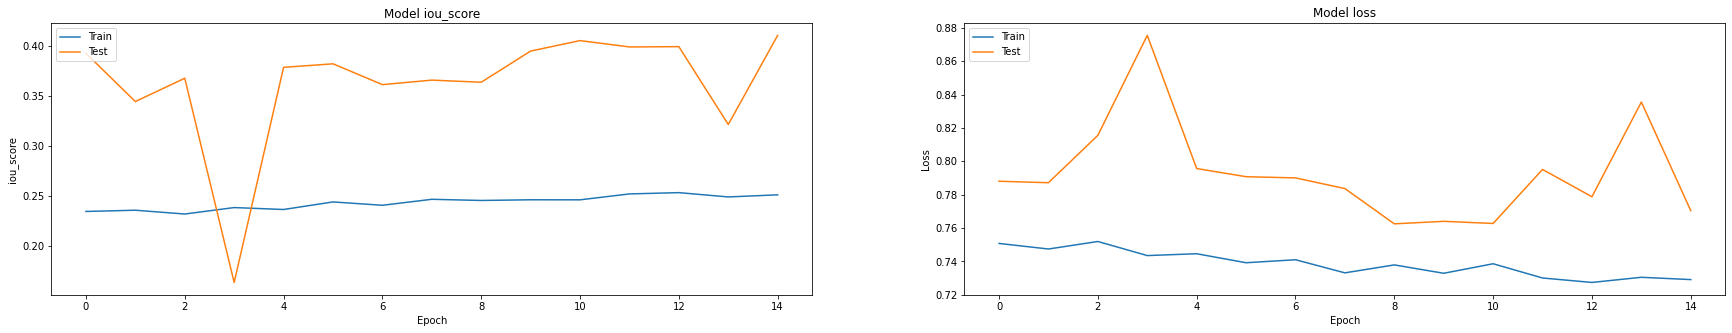

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions

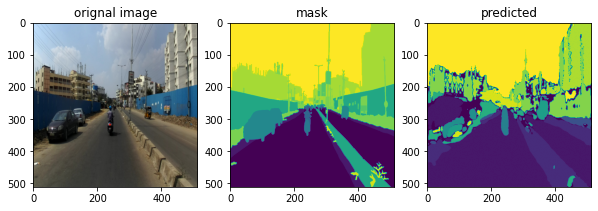

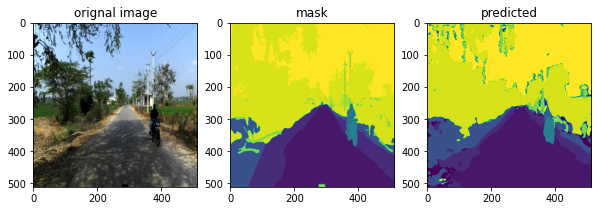

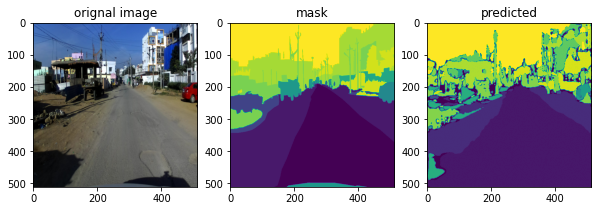

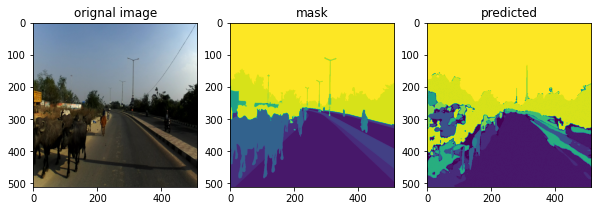

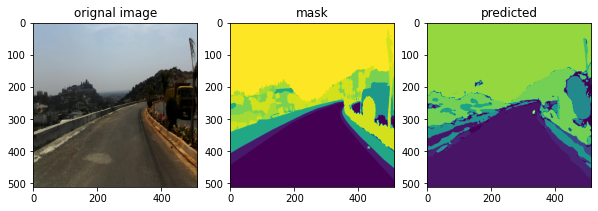

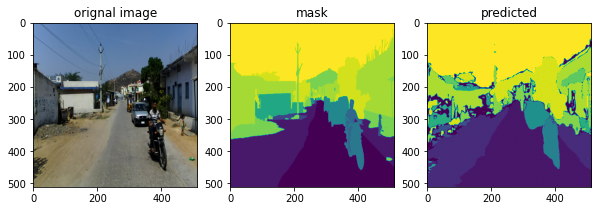

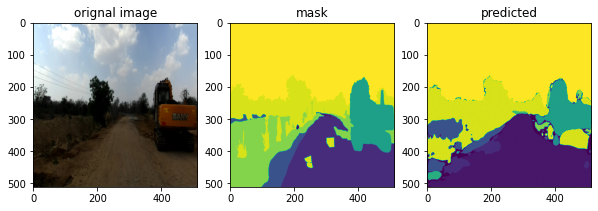

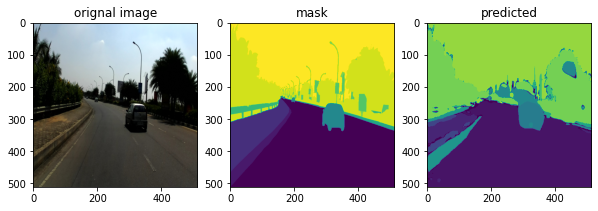

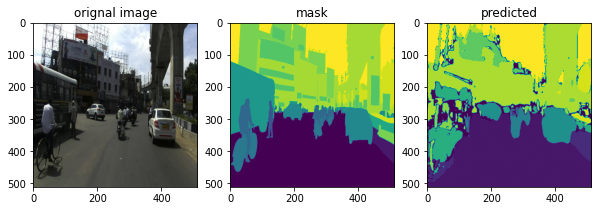

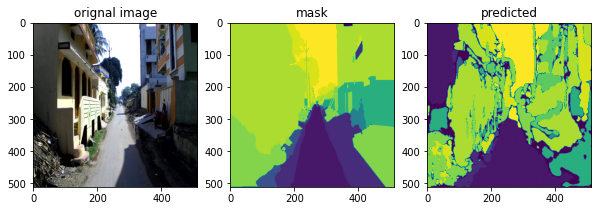

In [ ]:
plot_images=X_val[:10].reset_index(drop=True)
x=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,18,190,200]

for p, i in enumerate(range(10)):
    #original image
    image = cv2.imread(plot_images['images'][p], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=normalize(image)
    
    
    #predicted segmentation map
    predicted  =np.where(model.predict(np.array([image]))>0.5,1,0)
   
    m=np.zeros((512,512))
    for j , k in enumerate(x):
      b=np.where(predicted[0][:,:,j]==1,k,0)
      m=m+b

    
    #original segmentation map
    image_mask = cv2.imread(plot_images['output'][p], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))[:,:,2]

    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image,)
    plt.title("orignal image")
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.title("mask")
    plt.subplot(133)
    plt.imshow(m)
    plt.title("predicted")
    plt.show()

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks